In [ ]:
# config
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

saved figure_convergence_to_distribution.pdf


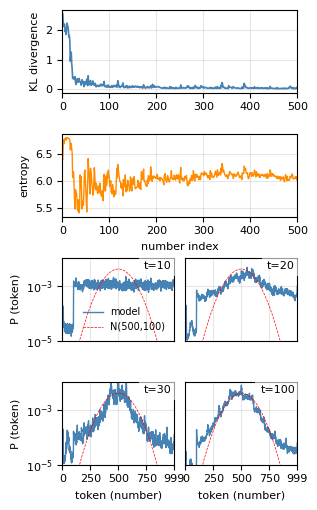

In [ ]:

DATASET = "gaussian_m500_s100_l1000_n10"
TEMPERATURE = 1.0
SEQUENCE_IDX = 0
MU, SIGMA = 500.0, 100.0
SAVE_FIGURE = False
NUMBER_RANGE = (0, 999)
POSITIONS_TO_PLOT = [10, 20, 30, 100]  # 1-based number indices
FIGURE_PATH = Path("figure_convergence_to_distribution.png")
EPS = 1e-12
CM = 1 / 2.54  # cm→in

BASE_DIR = Path.cwd().parent
LOGITS_DIR = BASE_DIR / "data" / "logits"


def load_sequence_logits(dataset: str, sequence_idx: int):
    base = LOGITS_DIR / dataset
    files = sorted(base.glob("logits_batch*.pt"))
    if not files:
        raise FileNotFoundError(f"No logits_batch*.pt found in {base}")

    remaining = sequence_idx
    for fpath in files:
        payload = torch.load(fpath, map_location="cpu")
        logits = payload["logits"]
        lengths = payload.get("lengths")
        if lengths is None:
            lengths = torch.full((logits.shape[0],), logits.shape[1], dtype=torch.long)
        batch_size = logits.shape[0]
        if remaining < batch_size:
            seq_len = int(lengths[remaining])
            seq_logits = logits[remaining, :seq_len]
            token_labels = payload.get("token_strings") or payload.get("token_labels")
            return seq_logits, token_labels
        remaining -= batch_size

    raise IndexError(f"sequence_idx={sequence_idx} out of range")


def numeric_subset(labels, lower: int, upper: int):
    entries = []
    for idx, label in enumerate(labels):
        try:
            val = int(label)
        except ValueError:
            continue
        if lower <= val <= upper:
            entries.append((val, idx))
    entries.sort(key=lambda pair: pair[0])
    values = np.array([v for v, _ in entries], dtype=np.int32)
    indices = [i for _, i in entries]
    return values, indices


def gaussian_over(values: np.ndarray, mu: float, sigma: float, eps: float):
    g = np.exp(-0.5 * ((values - mu) / sigma) ** 2)
    g = g / np.clip(g.sum(), eps, None)
    return np.clip(g, eps, None)


logits, labels = load_sequence_logits(DATASET, SEQUENCE_IDX)
probs = torch.softmax(logits / TEMPERATURE, dim=-1).cpu().numpy()
entropies = -np.sum(probs * np.log(np.clip(probs, EPS, None)), axis=-1)

seq_len_logits = probs.shape[0]
com_idx = np.arange(2, seq_len_logits, 2)  # comma→number positions
num_idx = np.arange(1, seq_len_logits, 2)  # number→comma positions (not plotted now)

# Entropy on comma→number positions
com_entropy = entropies[com_idx]

numeric_values, numeric_indices = numeric_subset(labels, *NUMBER_RANGE)
com_probs_numeric = probs[com_idx][:, numeric_indices]
com_probs_numeric = com_probs_numeric / np.clip(
    com_probs_numeric.sum(axis=1, keepdims=True), EPS, None
)

true_dist = gaussian_over(numeric_values, MU, SIGMA, EPS)
# KL(Model || True) per comma→number position
kl_div = np.sum(
    com_probs_numeric * (np.log(com_probs_numeric + EPS) - np.log(true_dist + EPS)),
    axis=1,
)

fig = plt.figure(figsize=(7.7 * CM, 15 * CM))
gs = fig.add_gridspec(4, 2, hspace=0.5, wspace=0.1)

ax_kl = fig.add_subplot(gs[0, :])
ax_com_ent = fig.add_subplot(gs[1, :])
dist_axes = [
    fig.add_subplot(gs[2, 0]),
    fig.add_subplot(gs[2, 1]),
    fig.add_subplot(gs[3, 0]),
    fig.add_subplot(gs[3, 1]),
]

# Row 1: KL vs position
x_com = np.arange(1, len(kl_div) + 1)
ax_kl.plot(x_com, kl_div, color="steelblue", lw=1.2)
# ax_kl.set_title("KL(Model ‖ N(500,100)) | comma→number")
ax_kl.set_ylabel("KL divergence")
ax_kl.set_xlim(0, 500)
ax_kl.grid(True, alpha=0.3)

# Row 2: entropy of comma→number
ax_com_ent.plot(x_com, com_entropy, color="darkorange", lw=1.0)
# ax_com_ent.set_title("Entropy | comma→number")
ax_com_ent.set_xlabel("number index")
ax_com_ent.set_ylabel("entropy")
ax_com_ent.set_xlim(0, 500)
ax_com_ent.grid(True, alpha=0.3)

ax_kl.set_xlabel("", fontsize=8)
ax_kl.set_ylabel("KL divergence", fontsize=8)
ax_kl.tick_params(axis="both", which="both", labelsize=8)

ax_com_ent.set_xlabel("number index", fontsize=8)
ax_com_ent.set_ylabel("entropy", fontsize=8)
ax_com_ent.tick_params(axis="both", which="both", labelsize=8)

# Rows 3–4: distributions at selected positions with true Gaussian outline
for ax_i, (ax, t) in enumerate(zip(dist_axes, POSITIONS_TO_PLOT)):
    idx = t - 1  # 1-based to 0-based
    if idx >= com_probs_numeric.shape[0]:
        raise IndexError(f"Requested position t={t} exceeds available length {com_probs_numeric.shape[0]}")
    dist = com_probs_numeric[idx]
    ax.plot(numeric_values, dist, color="steelblue", lw=1.0, label="model")
    ax.plot(numeric_values, true_dist, color="red", lw=0.5, ls="--", label="N(500,100)")
    # ax.set_title(f"t={t}", fontsize=8)
    ax.text(
        0.98, 0.97, f"t={t}",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=8,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.6),  # optional backdrop
    )
    ax.set_xlabel("token (number)", fontsize=8)
    ax.set_ylabel("P (token)", fontsize=8)
    ax.set_yscale("log")
    ax.set_ylim(1e-5, 1e-2)
    ax.tick_params(axis="both", which="both", labelsize=8)
    ax.set_xticks([0, 250, 500, 750, 999])
    ax.grid(True, alpha=0.3)
    ax.set_xlim(NUMBER_RANGE)

    # only keep legend in (row 3, col 1)
    if ax_i == 0:
        ax.legend(frameon=False, fontsize=7)

    # strip y-axis labels/ticks for right-column plots
    if ax_i % 2 == 1:
        ax.set_ylabel("")
        ax.set_yticklabels([])
        ax.tick_params(axis="y", length=0)

    # strip x-axis on row 3 (ax_i 0,1)
    if ax_i < 2:
        ax.set_xlabel("")
        ax.set_xticklabels([])
        ax.tick_params(axis="x", length=0, labelbottom=False)

# fig.suptitle(f"{DATASET} | temp={TEMPERATURE} | seq={SEQUENCE_IDX}", fontsize=10)

if SAVE_FIGURE:
    # FIGURE_PATH.parent.mkdir(parents=True, exist_ok=True)
    FIGURE_PATH = Path("figure_convergence_to_distribution.pdf")
    fig.savefig(FIGURE_PATH, dpi=300, bbox_inches="tight")
    print(f"saved {FIGURE_PATH}")


/tmp/ipykernel_2914972/1740858900.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


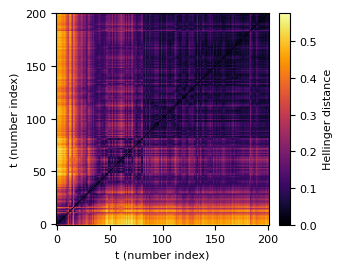

In [3]:
# Config 
DATASET = "gaussian_m500_s100_l1000_n10"
SAVE_FIGURE = False
TEMPERATURE = 1.0
NUMBER_RANGE = (0, 999)
EPS = 1e-12
SEQUENCE_IDX = 9

BASE_DIR = Path.cwd().parent
LOGITS_DIR = BASE_DIR / "data" / "logits"


def load_sequence_logits(dataset: str, sequence_idx: int):
    base = LOGITS_DIR / dataset
    files = sorted(base.glob("logits_batch*.pt"))
    if not files:
        raise FileNotFoundError(f"No logits_batch*.pt found in {base}")

    remaining = sequence_idx
    for fpath in files:
        payload = torch.load(fpath, map_location="cpu")
        logits = payload["logits"]
        lengths = payload.get("lengths")
        if lengths is None:
            lengths = torch.full((logits.shape[0],), logits.shape[1], dtype=torch.long)
        batch_size = logits.shape[0]
        if remaining < batch_size:
            seq_len = int(lengths[remaining])
            seq_logits = logits[remaining, :seq_len]
            token_labels = payload.get("token_strings") or payload.get("token_labels")
            return seq_logits, token_labels
        remaining -= batch_size

    raise IndexError(f"sequence_idx={sequence_idx} out of range")


# Load logits and build comma→number numeric distributions
logits, labels = load_sequence_logits(DATASET, SEQUENCE_IDX)
probs = torch.softmax(logits / TEMPERATURE, dim=-1).cpu().numpy()

seq_len = probs.shape[0]
com_idx = np.arange(2, seq_len, 2)

entries = []
for idx, lbl in enumerate(labels):
    try:
        val = int(lbl)
    except ValueError:
        continue
    if NUMBER_RANGE[0] <= val <= NUMBER_RANGE[1]:
        entries.append((val, idx))
entries.sort(key=lambda x: x[0])
numeric_values = np.array([v for v, _ in entries], dtype=np.int32)
numeric_indices = [i for _, i in entries]

com_probs_numeric = probs[com_idx][:, numeric_indices]
com_probs_numeric = com_probs_numeric / np.clip(com_probs_numeric.sum(axis=1, keepdims=True), EPS, None)

# Hellinger distance matrix for t = 0..200
def hellinger_matrix(dists: np.ndarray) -> np.ndarray:
    sqrt_d = np.sqrt(np.clip(dists, EPS, None))
    gram = sqrt_d @ sqrt_d.T
    row_norm = np.sum(sqrt_d**2, axis=1, keepdims=True)
    sq_dist = row_norm + row_norm.T - 2 * gram
    return np.sqrt(0.5 * np.clip(sq_dist, 0.0, None))

max_t = min(200, com_probs_numeric.shape[0] - 1)
sel = slice(0, max_t + 1)
hell = hellinger_matrix(com_probs_numeric[sel])

CM = 1 / 2.54
fig, (ax, cax) = plt.subplots(
    ncols=2,
    figsize=(7.7 * CM, 7 * CM),
    gridspec_kw={"width_ratios": [1, 0.05], "wspace": 0.08},
)

im = ax.imshow(hell, origin="lower", cmap="inferno")
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("Hellinger distance", fontsize=8)
cbar.ax.tick_params(labelsize=8)

ax.set_xlabel("t (number index)", fontsize=8)
ax.set_ylabel("t (number index)", fontsize=8)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

if SAVE_FIGURE:
    out_path = Path("figures/fig_hellinger_matrix.pdf")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, bbox_inches="tight")
    print(f"saved {out_path}")
